# With TensorFlow

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/compose_with_tf.ipynb)

## About this tutorial

This tutorial shows how to combine YDF decision forest models with TensorFlow neural network models. Such composed models are typically used to improve model quality and consume unstructured data.

First, we show how to "stack" a decision forest model on top of a pre-trained neural network model. This approach is particularly useful for the "pre-trained embedding" method: Instead of training a model directly on the features, we train or use an existing model trained on abundant similar-looking data. The output of this first model then serves as the input for a second model trained on our limited dataset. The "pre-trained embedding" approach also simplifies model development for text or images. While text or images require some effort to be fed into a model, embeddings, also known as intermediate representations, are easier to train on.

![compose_with_tf_stack](../../image/tutorial/compose_with_tf_stack.png)

In the second part, we show how to ensemble multiple decision forest and neural network models. Ensembling with different model types can leverage their complementary strengths as decision forests excel in some examples, while neural networks are superior in others.

![compose_with_tf_ensemble](../../image/tutorial/compose_with_tf_ensemble.png)

## Setup

In [ ]:
# Install YDF and TensorFlow
!pip install ydf -U -q
!pip install tensorflow -U -q

## Stacking a decision forest and a pre-trained neural network model

For this example, we train a model on the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) text classification dataset.
The prediction task is to classify movie reviews as positive (label 1) or negative (label 0).
The dataset is available in [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/glue#gluesst2).

In [ ]:
# Install TensorFlow Dataset
!pip install tensorflow-datasets -U -q

In [2]:
# Load the Stanford Sentiment Treebank dataset

import tensorflow_datasets as tfds
raw_dataset = tfds.load("glue/sst2")
raw_train_dataset = raw_dataset["train"].batch(200)
raw_test_dataset = raw_dataset["validation"].batch(200)
# Note: The `raw_dataset["test"]` fold does not have labels. Therefore, we use the
# "validation" fold for testing.

# Display the first 3 test examples.
for example in raw_test_dataset.rebatch(1).take(3):
    print("label:", example["label"].numpy())
    print("sentence:", example["sentence"].numpy())
    print("")

label: [0]
sentence: [b'a valueless kiddie paean to pro basketball underwritten by the nba . ']

label: [1]
sentence: [b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "]

label: [0]
sentence: [b'i am sorry that i was unable to get the full brunt of the comedy . ']



2024-04-12 10:19:56.151619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-12 10:19:56.151977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The Stanford Sentiment Treebank dataset is relatively small. So instead of training directly on it, we will use an already trained text model. For instance we will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) neural network which has been trained on a much larger dataset. By reusing USE, we can train a text model quickly and without the need for large datasets.

We use the Universal-Sentence-Encoder available on the TensorFlow Hub website. For other types of unstructured data (e.g., images or audio), corresponding pre-trained models can be found on the TensorFlow Hub website.

In [ ]:
# Install TensorFlow Hub
!pip install tensorflow-hub -U -q

We load the Universal-Sentence-Encoder.

In [3]:
import tensorflow_hub as hub

pretrained_neural_network_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

We apply the Universal-Sentence-Encoder to convert the raw text into embeddings.

In [4]:
import numpy as np

def apply_neural_network_model(data):
    return {
        "embedding": pretrained_neural_network_model(data["sentence"]),
        "label": data["label"],
    }
    
processed_train_dataset = raw_train_dataset.map(apply_neural_network_model)
processed_test_dataset = raw_test_dataset.map(apply_neural_network_model)

# Display the first 3 processed test examples.
for example in processed_test_dataset.rebatch(1).take(3):
    print("label:", example["label"].numpy())
    print("embedding:", np.array2string(example["embedding"].numpy(), threshold = 10))
    print("")

label: [0]
embedding: [[ 0.0325069   0.02350717  0.0928923  ... -0.05117338 -0.0959709
   0.01819227]]

label: [1]
embedding: [[-0.02955496  0.04451125  0.03023855 ...  0.02529242  0.06243655
   0.0004012 ]]

label: [0]
embedding: [[-0.02897574 -0.0021273   0.02524822 ... -0.00667133  0.07221754
   0.05386261]]



2024-04-12 10:20:03.889224: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-12 10:20:03.889676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Then, we train a gradient-boosted trees model on the Neural Network output.

In [5]:
import ydf

decision_forest_model = ydf.GradientBoostedTreesLearner(label="label", num_trees=100).train(processed_train_dataset)

Train model on 67349 examples
Model trained in 0:00:54.704927


Notice that the YDF model is trained on a TensorFlow Dataset directly.

Looking at the more is important.

In [6]:
decision_forest_model.describe()

The decision forest model use 512 numerical features as input. These are the 512 dimensions of the embedding generated by the neural network.

Then, we evaluate the model quality.

In [7]:
decision_forest_model.evaluate(processed_test_dataset)

Label \ Pred,1,0
1,365,102
0,79,326


To simplify productionization, it is often good to save together the decision forest model and the preprocessing neural network together in a single model.

In [8]:
# Converts the YDF decision forest model into a TensorFlow function.
tf_decision_forest_model = decision_forest_model.to_tensorflow_function()

[INFO 24-04-12 10:21:03.6602 CEST kernel.cc:1233] Loading model from path /tmp/tmpicaxyl1d/ with prefix a15dba1c_
[INFO 24-04-12 10:21:03.6767 CEST quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-04-12 10:21:03.6774 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-12 10:21:03.6775 CEST kernel.cc:1061] Use fast generic engine


In [9]:
# Save both the decision forests and pre-processing neural network to a TensorFlow SaveModel.
import tensorflow as tf

# The stacked model applies the neural network and decision forest models in sequence.
class StackedModel(tf.Module):

    def __init__(self, nn, df):
        self._nn = nn
        self._df = df

    @tf.function
    def __call__(self, raw_features):
        sentence = raw_features["sentence"]
        embedding = self._nn(sentence)
        processed_features = {"embedding": embedding} 
        return self._df(processed_features)

stacked_model = StackedModel(pretrained_neural_network_model, tf_decision_forest_model)

# Run the stacked model on the first 3 test examples.
for example in raw_test_dataset.rebatch(1).take(3):
    print("label:", example["label"].numpy())
    print("sentence:", example["sentence"].numpy())
    prediction = stacked_model({"sentence": example["sentence"]})
    print("predictions:", prediction)
    print("")

label: [0]
sentence: [b'a valueless kiddie paean to pro basketball underwritten by the nba . ']
predictions: tf.Tensor([0.8391822], shape=(1,), dtype=float32)

label: [1]
sentence: [b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "]
predictions: tf.Tensor([0.23475255], shape=(1,), dtype=float32)

label: [0]
sentence: [b'i am sorry that i was unable to get the full brunt of the comedy . ']
predictions: tf.Tensor([0.8494433], shape=(1,), dtype=float32)



2024-04-12 10:21:05.527045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We can then save this stacked model for later.

In [10]:
tf.saved_model.save(stacked_model, "/tmp/my_stacked_model")

The model can then be reloaded and reused.

In [11]:
loaded_stacked_model = tf.saved_model.load("/tmp/my_stacked_model")

loaded_stacked_model({"sentence":["This is a great movie"]}).numpy()

[INFO 24-04-12 10:21:12.4042 CEST kernel.cc:1233] Loading model from path /tmp/my_stacked_model/assets/ with prefix a15dba1c_
[INFO 24-04-12 10:21:12.4235 CEST kernel.cc:1061] Use fast generic engine


array([0.02682637], dtype=float32)

The model saved in `"/tmp/my_stacked_model"` above accepts raw tensor values as input. This is ideal for Python model development.

Although such models can be used in TensorFlow Serving or Vertex AI, it is more common for models in these platforms to use a serialized TensorFlow Example as input and output a dictionary. Here's how to create such a model:

In [12]:
@tf.function(input_signature=[tf.TensorSpec([None], dtype=tf.string, name="inputs")])
def predict_with_with_proto_input(serialized_examples: tf.Tensor):

    # Extract the features
    feature_spec = {"sentence": tf.io.FixedLenFeature(shape=[], dtype=tf.string)}
    features = tf.io.parse_example(serialized_examples, feature_spec)

    # Make predictions
    predictions = stacked_model(features)
    
    return {"scores": predictions}
    
tf.saved_model.save(stacked_model, "/tmp/my_stacked_model_with_proto_input",
                    signatures = {tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY: predict_with_with_proto_input})

## Training an ensemble of neural network and decision forests models

For this example, we train and ensemble together a random forest model, a gradient-boosted trees model, and a neural network model on a simple synthetic dataset.

In [13]:
# A function to generate a synthetic dataset
def make_dataset(num_examples=10000, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, 4))
  noise = np.random.uniform(size=(num_examples))
  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5
  labels = left_side <= right_side
  return {"features": features, "label": labels.astype(int) }

We generate and plot some examples:

In [14]:
make_dataset(num_examples=5)

{'features': array([[-0.6169611 ,  0.24421754, -0.12454452,  0.57071717],
        [ 0.55995162, -0.45481479, -0.44707149,  0.60374436],
        [ 0.91627871,  0.75186527, -0.28436546,  0.00199025],
        [ 0.36692587,  0.42540405, -0.25949849,  0.12239237],
        [ 0.00616633, -0.9724631 ,  0.54565324,  0.76528238]]),
 'label': array([0, 0, 0, 1, 0])}

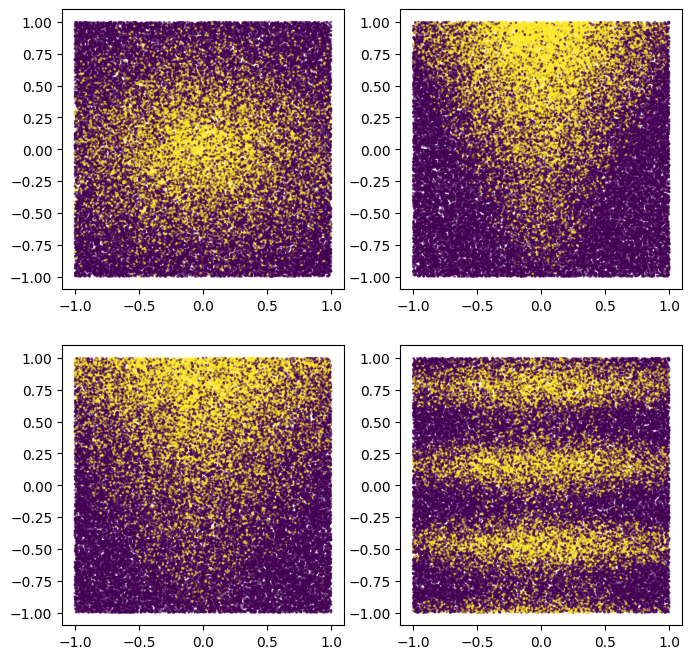

In [15]:
import matplotlib.pyplot as plt

plot_dataset = make_dataset(num_examples=50000)
plot_label = plot_dataset["label"]
plot_features = plot_dataset["features"]
plt.rcParams["figure.figsize"] = [8, 8]
common_args = dict(c=plot_label, s=1.0, alpha=0.5)
plt.subplot(2, 2, 1)
plt.scatter(plot_features[:, 0], plot_features[:, 1], **common_args)
plt.subplot(2, 2, 2)
plt.scatter(plot_features[:, 1], plot_features[:, 2], **common_args)
plt.subplot(2, 2, 3)
plt.scatter(plot_features[:, 0], plot_features[:, 2], **common_args)
plt.subplot(2, 2, 4)
plt.scatter(plot_features[:, 0], plot_features[:, 3], **common_args)

Note that this pattern is smooth and not aligned horizontally or vertically. This will advantage the neural network models. This is because it is easier for a neural network than for a decision tree to have round and non aligned decision boundaries.

On the other hand, we will train the model on a small datasets with 2500 examples. This will advantage the decision forest models. This is because decision forests are much more efficient, using all the available information from the examples (decision forests are "sample efficient").

Our ensemble of neural networks and decision forests will use the best of both worlds.

In [16]:
train_dataset = make_dataset(num_examples=10000, seed=1234)
test_dataset = make_dataset(num_examples=10000, seed=5678)

First, let's train the a random forest and gradient-boosted trees models.

In [17]:
model_random_forest = ydf.RandomForestLearner(label="label").train(train_dataset)
model_gradient_boosted_trees = ydf.GradientBoostedTreesLearner(label="label").train(train_dataset)

Train model on 10000 examples
Model trained in 0:00:00.280004
Train model on 10000 examples
Model trained in 0:00:01.720190


Then, let's train the neural network models.

In [18]:
def make_tf_dataset(dataset, batch_size):
    # Note: Keras expects the label and the features to be separated.
    return tf.data.Dataset.from_tensor_slices((
            {"features":dataset["features"]},
            dataset["label"],
        )).batch(batch_size)

tf_train_dataset = make_tf_dataset(train_dataset, 100)
tf_test_dataset = make_tf_dataset(test_dataset, 100)

inputs = [tf.keras.Input(shape=(4,), name="features")]
x = tf.keras.layers.concatenate(inputs)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dense(1)(x)
model_neural_network = tf.keras.Model(inputs=inputs, outputs=x)
model_neural_network.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
model_neural_network.fit(tf_train_dataset, epochs=5)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7168 - loss: 0.6956 
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.7457 - loss: 0.5865
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.7457 - loss: 0.5270
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7457 - loss: 0.4865
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7492 - loss: 0.4557


We evaluate all our models individually.

In [19]:
model_random_forest.evaluate(test_dataset).accuracy

0.9476

In [20]:
model_gradient_boosted_trees.evaluate(test_dataset).accuracy

0.9674

In [21]:
model_neural_network.evaluate(tf_test_dataset, return_dict=True)["accuracy"]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.7546 - loss: 0.4397


0.7534999847412109

Let's combine together the tree models.

In [22]:
class EnsembleModel(tf.keras.Model):

    def __init__(self, rf, gbt, nn):
        super().__init__()
        self._rf = rf
        self._gbt = gbt
        self._nn = nn

    def call(self, features):
        individual_predictions = []
        
        # Note: For binary classification, the shape of YDF output
        # is [num example], while the shape of a Keras model output
        # if [num example, 1]. Keras' evaluation requires a [num example, 1]
        # shaped output.
        individual_predictions.append(tf.expand_dims(self._rf(features), axis=1))
        individual_predictions.append(tf.expand_dims(self._gbt(features), axis=1))
        
        # Note: The model outputs a logit, not a probability.
        individual_predictions.append(tf.nn.sigmoid(self._nn(features)))

        return tf.reduce_mean(tf.stack(individual_predictions, axis=0), axis=0)
        
ensemble_model = EnsembleModel(
    rf = model_random_forest.to_tensorflow_function(),
    gbt = model_gradient_boosted_trees.to_tensorflow_function(),
    nn = model_neural_network
)

[INFO 24-04-12 10:21:22.5101 CEST kernel.cc:1233] Loading model from path /tmp/tmpesx684rq/ with prefix 38f4c229_
[INFO 24-04-12 10:21:23.0956 CEST decision_forest.cc:734] Model loaded with 300 root(s), 197576 node(s), and 4 input feature(s).
[INFO 24-04-12 10:21:23.0956 CEST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-12 10:21:23.0956 CEST kernel.cc:1061] Use fast generic engine
[INFO 24-04-12 10:21:23.1543 CEST kernel.cc:1233] Loading model from path /tmp/tmps0kyvz4d/ with prefix cca7e657_
[INFO 24-04-12 10:21:23.1960 CEST kernel.cc:1061] Use fast generic engine


We print the predictions of the first 3 test examples.

In [23]:
for features, labels in tf_test_dataset.rebatch(1).take(3):
    print("features:", features)
    print("labels:", labels)
    prediction = ensemble_model(features)
    print("prediction:", prediction)

features: {'features': <tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[-0.02134604, -0.88133511, -0.26759515,  0.03773088]])>}
labels: tf.Tensor([0], shape=(1,), dtype=int64)
prediction: tf.Tensor([[0.06539446]], shape=(1, 1), dtype=float32)
features: {'features': <tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[ 0.19645002, -0.13877101, -0.64273189, -0.4294922 ]])>}
labels: tf.Tensor([1], shape=(1,), dtype=int64)
prediction: tf.Tensor([[0.57615477]], shape=(1, 1), dtype=float32)
features: {'features': <tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[-0.85712274, -0.63057332, -0.82434415,  0.47293716]])>}
labels: tf.Tensor([0], shape=(1,), dtype=int64)
prediction: tf.Tensor([[0.05497471]], shape=(1, 1), dtype=float32)


2024-04-12 10:21:23.264820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


And we evaluate the quality of the ensembled model.

In [24]:
ensemble_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
ensemble_model.evaluate(tf_test_dataset, return_dict=True)["accuracy"]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 3.0788e-08   

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 3.0870e-08


0.9556999802589417

In this scenario, the ensemble outperforms the random forest and neural network, but falls behind the gradient-boosted trees model in terms of performance. When a model's quality is low (as is the case with the neural network in this instance), the ensemble's overall performance can be negatively impacted. The next step would be to either focus on enhancing the neural network's quality or to completely exclude it from the ensemble.